In [1]:
%matplotlib inline
import re
import pickle
import time
import numpy as np
import pandas as pd
import warnings
import operator
import polars as pl
from collections import defaultdict, Counter
def ignore_warn(*args,**kwargs):
    pass
warnings.warn = ignore_warn

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=['SimHei']
plt.rcParams["axes.unicode_minus"]=False

import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from IPython.display import HTML

import optuna
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import TruncatedSVD, PCA

from scipy.stats import norm,skew,boxcox_normmax

import xgboost as xgb
import lightgbm as lgb
import catboost as catb

In [2]:
path = '/root/autodl-tmp/Bio'
number = 20000
# traindata = pd.read_csv(f'{path}/traindata.csv', nrows = number)
trainmap = pd.read_csv(f'{path}/trainmap.csv')

# testdata = pd.read_csv(f'{path}/testdata.csv', nrows = number)
testmap = pd.read_csv(f'{path}/testmap.csv')

In [3]:
# traindata = traindata.set_index('cpgsite') # 将训练数据的索引设置为'cpgsite'列
# traindata = traindata.T # 转置训练数据
# traindata = traindata.reset_index() # 重置训练数据的索引
# traindata = traindata.rename(columns={'index':'sample_id'}) # 重命名训练数据的列名
# traindata.columns = ['sample_id'] + [i for i in range(number)] # 设置训练数据的列名为'sample_id'加上一列自增的数字
# traindata.to_pickle(f'{path}/traindata_20000.pkl') # 将处理后的训练数据保存为pickle文件

# testdata = testdata.set_index('cpgsite') # 将测试数据的索引设置为'cpgsite'列
# testdata = testdata.T # 转置测试数据
# testdata = testdata.reset_index() # 重置测试数据的索引
# testdata = testdata.rename(columns={'index':'sample_id'}) # 重命名测试数据的列名
# testdata.columns = ['sample_id'] + [i for i in range(number)] # 设置测试数据的列名为'sample_id'加上一列自增的数字
# testdata.to_pickle(f'{path}/testdata_20000.pkl') # 将处理后的测试数据保存为pickle文件

In [4]:
with open(f'{path}/traindata_20000.pkl', 'rb') as file:
    traindata = pickle.load(file)

with open(f'{path}/testdata_20000.pkl', 'rb') as file:
    testdata = pickle.load(file)

# EDA

In [5]:
traindata

,sample_id,0,1,2,3,4,5,6,7,8,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,train10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.152395,-4.489850,-2.804368,3.659672,3.993781,3.007447,-3.619579,-2.276579,2.401172,-3.837361
1,train10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.462650,-4.247583,-2.767818,3.406479,4.051632,1.823018,-3.543689,-2.069693,2.230092,-2.401172
2,train10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.040530,-3.790034,-3.100385,3.701353,5.093549,2.616463,-3.343970,-2.049755,2.401172,-3.472874
3,train10004,NaN,NaN,NaN,NaN,NaN,-1.398461,NaN,NaN,NaN,...,1.030189,-3.993781,-3.374769,3.543689,4.178048,2.664729,-3.175661,-1.945225,2.441207,-2.570129
4,train10005,1.136022,-4.489850,NaN,-3.993781,1.312567,-2.901295,-4.585271,2.804368,2.985388,...,1.179996,-4.247583,-2.823096,3.406479,4.112908,2.842141,-3.886935,-2.241551,2.401172,-3.029956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8228,train18229,1.991711,-3.886935,NaN,-3.256540,0.851873,-2.664729,-4.051632,2.842141,4.585271,...,2.049755,-4.322159,-3.076403,3.175661,5.093549,3.507691,-3.201956,-2.276579,3.029956,NaN
8229,train18230,2.020410,-3.938986,NaN,-3.543689,1.259524,-2.388119,-4.112908,3.472874,3.701353,...,1.672671,-3.343970,-3.343970,2.881228,4.807960,2.648415,-3.580953,-1.606561,2.616463,NaN
8230,train18231,1.814692,-3.343970,NaN,-3.580953,NaN,-2.570129,-4.585271,3.343970,4.585271,...,1.585160,-4.322159,-3.007447,3.149987,4.690541,2.842141,-3.406479,-1.367282,3.029956,NaN
8231,train18232,1.550147,-2.963760,NaN,-3.744756,1.443126,-0.904911,-4.585271,3.374769,3.837361,...,2.218738,-5.273603,-2.823096,3.175661,4.940737,2.681278,-3.007447,-1.462650,3.052934,-1.918093


In [6]:
trainmap

,Unnamed: 0,sample_id,age,gender,sample_type,disease
0,1,train10001,88.0,F,disease tissue,Alzheimer's disease
1,2,train10002,92.0,F,disease tissue,Alzheimer's disease
2,3,train10003,93.0,F,disease tissue,Alzheimer's disease
3,4,train10004,96.0,F,disease tissue,Alzheimer's disease
4,5,train10005,91.0,M,disease tissue,Alzheimer's disease
...,...,...,...,...,...,...
8228,8229,train18229,74.0,M,disease tissue,type 2 diabetes
8229,8230,train18230,74.0,M,disease tissue,type 2 diabetes
8230,8231,train18231,81.0,M,disease tissue,type 2 diabetes
8231,8232,train18232,67.0,M,disease tissue,type 2 diabetes


## 把数据分成健康和不健康

In [7]:
trainmap['sample_type'].value_counts()

sample_type
control           6266
disease tissue    1967
Name: count, dtype: int64

In [8]:
traindata = traindata.merge(trainmap[['sample_id', 'age', 'gender', 'sample_type', 'disease']],on='sample_id',how='left')
testdata = testdata.merge(testmap[['sample_id', 'gender']],on='sample_id',how='left')

In [9]:
traindata_control = traindata[traindata['sample_type'] == 'control']
traindata_disease = traindata[traindata['sample_type'] == 'disease tissue']

In [10]:
traindata_control = traindata_control.reset_index(drop = True)
traindata_disease = traindata_disease.reset_index(drop = True)

看一看target

<Axes: xlabel='age', ylabel='Density'>

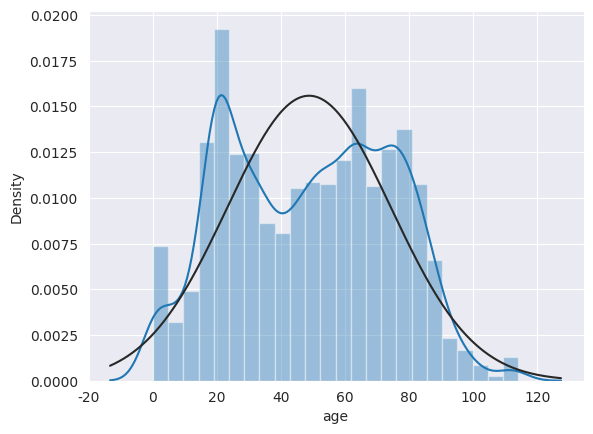

In [11]:
sns.distplot(traindata_control['age'], fit = norm)

<Axes: xlabel='age', ylabel='Density'>

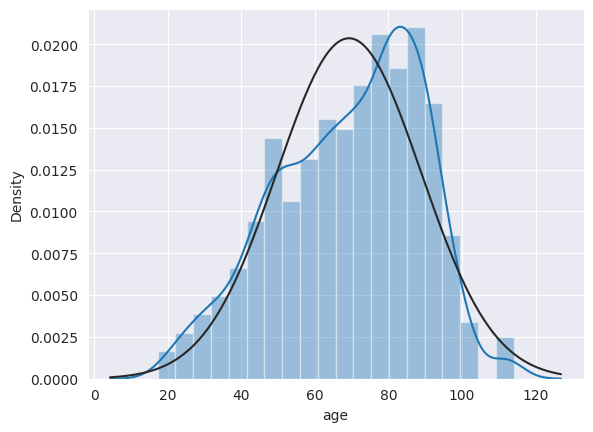

In [12]:
sns.distplot(traindata_disease['age'], fit = norm)

生病的老年人居多，生不生病对年龄的预测应该影响还是有的

## Gender VS 是否生病

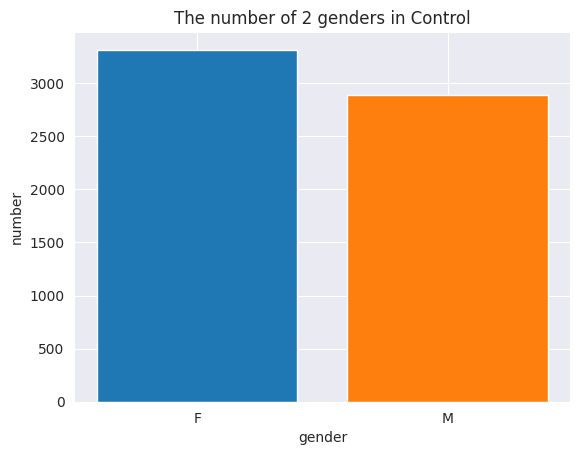

In [13]:
labels = [str(i) for i in traindata_control['gender'].value_counts().keys().tolist()]
for i in range(len(labels)):
    plt.bar(labels[i], traindata_control['gender'].value_counts().tolist()[i])

plt.title("The number of 2 genders in Control")
plt.xlabel("gender")
plt.ylabel("number")
 
plt.show()

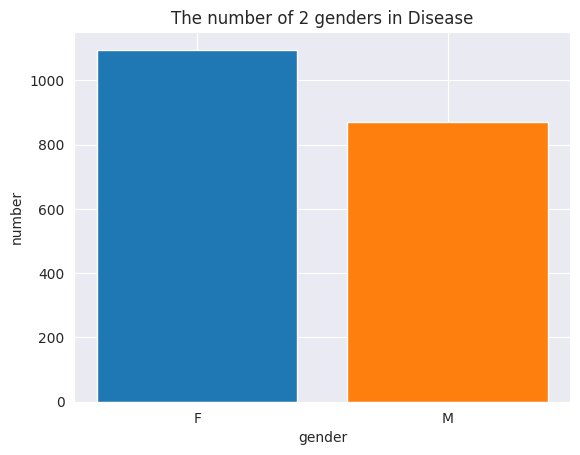

In [14]:
labels = [str(i) for i in traindata_disease['gender'].value_counts().keys().tolist()]
for i in range(len(labels)):
    plt.bar(labels[i], traindata_disease['gender'].value_counts().tolist()[i])

plt.title("The number of 2 genders in Disease")
plt.xlabel("gender")
plt.ylabel("number")
 
plt.show()

看来性别对是否生病影响不大，但可能影响甲基化数据的大小

## Gender VS 年龄

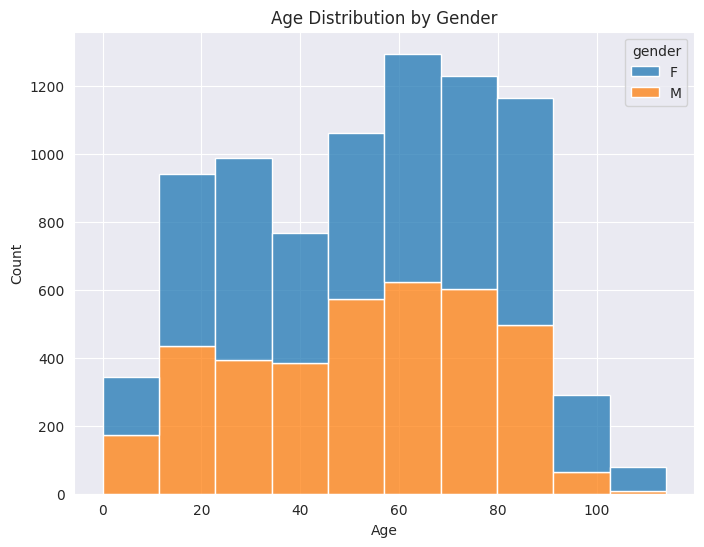

In [15]:
plt.figure(figsize=(8, 6))
sns.histplot(data=traindata, x='age', hue='gender', multiple='stack', bins=10)
plt.title('Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

感觉gender影响不大

## 疾病种类 VS 年龄

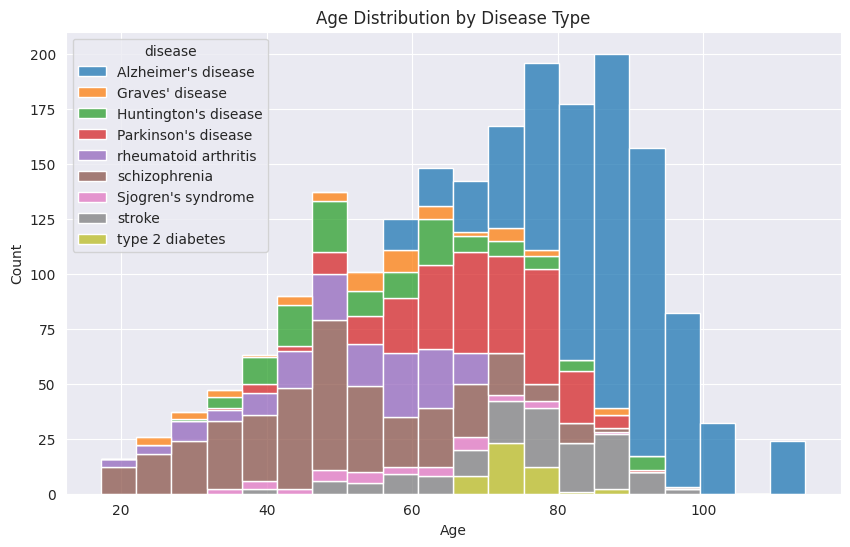

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=traindata_disease, x='age', hue='disease', multiple='stack', bins=20)

plt.title('Age Distribution by Disease Type')
plt.xlabel('Age')
plt.ylabel('Count')

plt.show()

影响有亿点大

## 缺失值

In [17]:
all_data = pd.concat([traindata.iloc[:, 1:-4], testdata.iloc[:, 1:-1]])
all_data

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.152395,-4.489850,-2.804368,3.659672,3.993781,3.007447,-3.619579,-2.276579,2.401172,-3.837361
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.462650,-4.247583,-2.767818,3.406479,4.051632,1.823018,-3.543689,-2.069693,2.230092,-2.401172
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.040530,-3.790034,-3.100385,3.701353,5.093549,2.616463,-3.343970,-2.049755,2.401172,-3.472874
3,NaN,NaN,NaN,NaN,NaN,-1.398461,NaN,NaN,NaN,NaN,...,1.030189,-3.993781,-3.374769,3.543689,4.178048,2.664729,-3.175661,-1.945225,2.441207,-2.570129
4,1.136022,-4.489850,NaN,-3.993781,1.312567,-2.901295,-4.585271,2.804368,2.985388,-4.402578,...,1.179996,-4.247583,-2.823096,3.406479,4.112908,2.842141,-3.886935,-2.241551,2.401172,-3.029956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.557086,-4.178048,-3.029956,3.284902,4.940737,2.681278,-2.963760,-1.306594,2.942546,-1.882748
2059,2.049755,-3.406479,NaN,-3.175661,1.125184,-2.337277,-4.489850,3.472874,4.489850,-3.744756,...,1.891498,-3.701353,-3.052934,3.149987,4.940737,3.543689,-3.580953,-1.882748,3.343970,-2.632328
2060,2.207487,-3.076403,NaN,-3.472874,NaN,-1.900305,-4.489850,3.052934,4.489850,-4.178048,...,1.865415,-4.322159,-3.124904,2.985388,9.210440,NaN,-3.343970,-1.404768,2.985388,-2.349789
2061,1.749816,-2.942546,NaN,-5.273603,NaN,-1.098346,-5.093549,3.406479,3.993781,-3.886935,...,2.861514,-3.993781,-3.149987,3.284902,5.093549,3.100385,-3.374769,-1.282902,2.942546,NaN


In [18]:
missing_counts = all_data.iloc[:, 1:-4].isnull().sum()
missing_ratios = (all_data.iloc[:, 1:-4].isnull().sum() / len(all_data)) * 100

top_missing = missing_ratios.sort_values(ascending=False)
top_missing[:30]

17141    98.552836
11379    98.348873
12919    97.736985
1389     97.533023
5144     97.338772
14628    97.309635
16914    97.231935
11910    97.163947
8393     96.901709
14301    96.746309
1926     96.717172
10168    96.678322
3279     96.542347
5911     95.930458
9361     95.823621
17088    95.736208
12485    95.707071
7365     95.707071
5878     95.707071
14265    95.697358
11631    95.677933
15081    95.648796
2        95.619658
3546     95.590521
8003     95.561383
17601    95.357420
4551     95.347708
1742     95.250583
7151     95.114608
10575    95.066045
dtype: float64

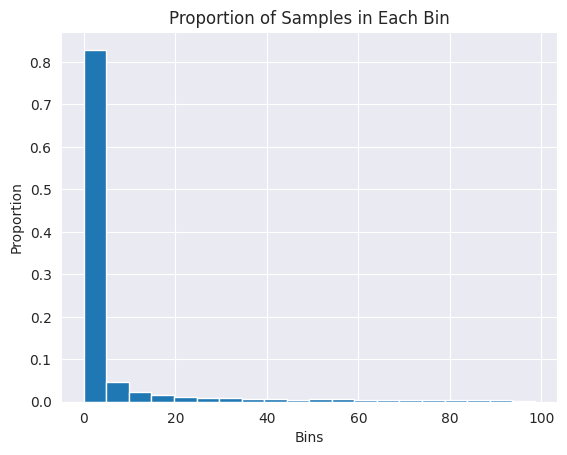

In [19]:
num_bins = 20

hist, bin_edges = np.histogram(top_missing, bins=num_bins)

bin_proportions = hist / len(top_missing)

plt.bar(bin_edges[:-1], bin_proportions, width=bin_edges[1] - bin_edges[0], align='edge')
plt.xlabel('Bins')
plt.ylabel('Proportion')
plt.title('Proportion of Samples in Each Bin')
plt.show()

In [20]:
bin_proportions

array([0.82890723, 0.04691173, 0.02250563, 0.01660415, 0.01010253,
       0.00900225, 0.0076019 , 0.00740185, 0.00550138, 0.00495124,
       0.00655164, 0.00690173, 0.00395099, 0.00375094, 0.00325081,
       0.00420105, 0.00330083, 0.00325081, 0.00305076, 0.00230058])

In [21]:
 bin_edges

array([ 0.        ,  4.9276418 ,  9.85528361, 14.78292541, 19.71056721,
       24.63820901, 29.56585082, 34.49349262, 39.42113442, 44.34877622,
       49.27641803, 54.20405983, 59.13170163, 64.05934343, 68.98698524,
       73.91462704, 78.84226884, 83.76991064, 88.69755245, 93.62519425,
       98.55283605])

In [22]:
sum(top_missing < 90)

19907

1. 删掉部分特征，这里选择80%以上的
2. 保存20%以内的特征然后进行PCA降维

我选择第二种来打开baseline（PS: PCA之后效果不是很好）

## Reduce Dimensonality

In [23]:
# imputer = SimpleImputer(strategy='mean')
# traindata_control_ = traindata_control.iloc[:, top_missing[top_missing < 20].index.tolist()]
# filled_traindata_control_ = imputer.fit_transform(traindata_control_)

# imputer_ = SimpleImputer(strategy='mean')
# traindata_disease_ = traindata_disease.iloc[:, top_missing[top_missing < 20].index.tolist()]
# filled_traindata_disease_ = imputer_.fit_transform(traindata_disease_)

In [24]:
# imputer_test = SimpleImputer(strategy='mean')
# testdata_ = testdata.iloc[:, top_missing[top_missing < 20].index.tolist()]
# filled_testdata_ = imputer_test.fit_transform(testdata_)

In [25]:
# alldata = pd.concat([pd.DataFrame(filled_traindata_control_), pd.DataFrame(filled_traindata_disease_), pd.DataFrame(filled_testdata_)])
# alldata

In [26]:
# alldata.info()

In [27]:
# variances = []
# for n_components in range(2, 200):
#     pca = PCA(n_components=n_components)
#     pca.fit(alldata)
#     variances.append(np.sum(pca.explained_variance_ratio_))

In [28]:
# plt.figure(figsize=(6,4))
# plt.plot([i for i in range(2, 200)], variances, color="red", linewidth=1 )
# plt.xlabel("n_components")
# plt.ylabel("variance")
# plt.title("n_components VS variance")

In [29]:
# plt.figure(figsize=(6,4))
# plt.plot([i for i in range(2, 40)], variances[:38], color="red", linewidth=1 )
# plt.xlabel("n_components")
# plt.ylabel("variance")
# plt.title("n_components VS variance")

选择第15作为PCA的n_components

In [30]:
# pca = PCA(n_components=15)
# alldata_pca = pca.fit_transform(alldata)
# alldata_pca

In [31]:
# train_pca = pd.DataFrame(alldata_pca[:len(traindata), :])
# test_pca = pd.DataFrame(alldata_pca[len(traindata):, :])

## Preprocessing

In [34]:
disease_mapping = {
    'control': 0,
    "Alzheimer's disease": 1,
    "Graves' disease": 2,
    "Huntington's disease": 3,
    "Parkinson's disease": 4,
    'rheumatoid arthritis': 5,
    'schizophrenia': 6,
    "Sjogren's syndrome": 7,
    'stroke': 8,
    'type 2 diabetes': 9
}
sample_type_mapping = {'control': 0, 'disease tissue': 1}
gender_mapping = {'F': 0, 'M': 1}

traindata['disease'] = traindata['disease'].map(disease_mapping)
traindata['sample_type'] = traindata['sample_type'].map(sample_type_mapping)
traindata['gender'] = traindata['gender'].map(gender_mapping)
testdata['gender'] = testdata['gender'].map(gender_mapping)

In [38]:
traindata_ = traindata.loc[:, top_missing[top_missing < 90].index.tolist() + ['gender']]
testdata_ = testdata.loc[:, top_missing[top_missing < 90].index.tolist() + ['gender']]

In [ ]:
traindata_control = traindata_[traindata_['sample_type'] == 0]
traindata_disease = traindata_[traindata_['sample_type'] == 1]

traindata_control = traindata_control.reset_index(drop = True)
traindata_disease = traindata_disease.reset_index(drop = True)

# Modeling

In [39]:
n_folds = 5
seed = 617

def CV(model, x, y):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    kfold = kf.split(x, y)
    losses = []
    for (train_id, val_id) in kfold:
        x_train = x.iloc[train_id]
        y_train = y[train_id]
        x_val = x.iloc[val_id]
        y_val = y[val_id]
        model.fit(x_train, y_train)
        pred = model.predict(x_val)
        loss = mean_absolute_error(y_val, pred)
        losses.append(loss)
    return np.mean(losses)

## Baseline

## LightGBM

In [35]:
def get_metric(model, x, y):
    model.fit(x, y)
    y_predict = model.predict(x)
    return mean_absolute_error(y, y_predict)

In [36]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'min_child_weight': 6,
    'num_leaves': 2 ** 6,
    'lambda_l2': 10,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 4,
    'learning_rate': 0.1,
    'seed': 2023,
    'nthread' : 16,
    'verbose' : -1,
}

In [40]:
lgbC = lgb.LGBMRegressor(**lgb_params, random_state = seed)
get_metric(lgbC, traindata_, traindata.iloc[:, -4])

1.008425879879112

In [129]:
# testdata['age'] = lgbC.predict(test_pca)
# testdata['age'] = testdata['age'].astype(float) # 将age列的数据类型转换为浮点数。
# testdata['age'] = testdata['age'].apply(lambda x: x if x>0 else 0.0) # 使用lambda函数对age列中的每个元素进行判断，如果大于0，则保持不变，否则将其替换为0.0。
# testdata['age'] = testdata['age'].apply(lambda x: '%.2f' % x) # 使用lambda函数将age列中的每个元素格式化为保留两位小数的字符串。
# testdata['age'] = testdata['age'].astype(str) # 将age列的数据类型转换为字符串。
# testdata[['sample_id','age']].to_csv('submit_lgb.txt',index=False)